In [1]:
! pip install pyro-ppl 

     |████████████████████████████████| 678 kB 5.1 MB/s 


In [2]:
import os
from functools import partial
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pyro
import pyro.distributions as dist

In [3]:
# Set matplotlib settings
%matplotlib inline
plt.style.use('default')

In [4]:
DATA_URL = "https://d2hg8soec8ck9v.cloudfront.net/datasets/rugged_data.csv"
data = pd.read_csv(DATA_URL, encoding="ISO-8859-1")
df = data[["cont_africa", "rugged", "rgdppc_2000"]]
df = df[np.isfinite(df.rgdppc_2000)]
df["rgdppc_2000"] = np.log(df["rgdppc_2000"])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


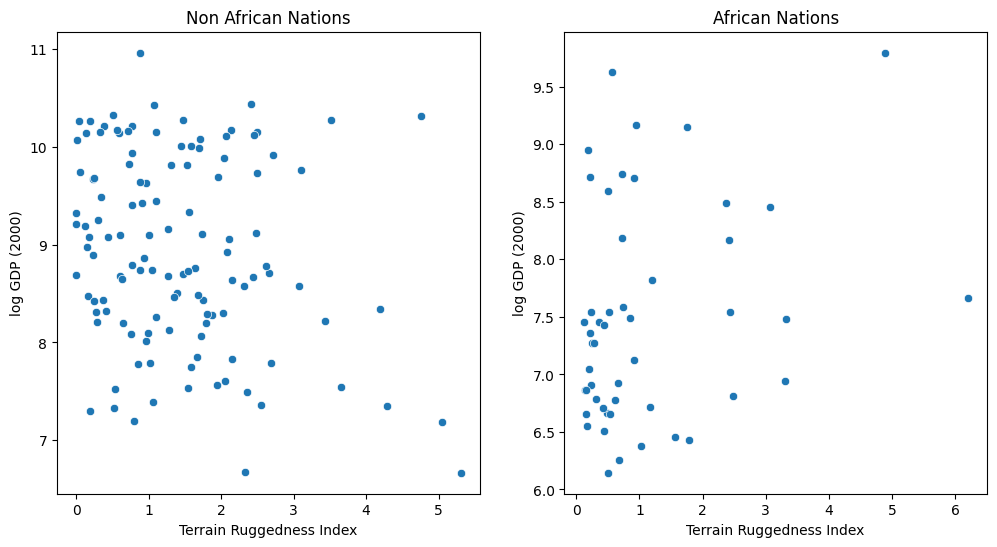

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=False)
african_nations = df[df["cont_africa"] == 1]
non_african_nations = df[df["cont_africa"] == 0]
sns.scatterplot(non_african_nations["rugged"],
            non_african_nations["rgdppc_2000"],
            ax=ax[0])
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")

sns.scatterplot(african_nations["rugged"],
                african_nations["rgdppc_2000"],
                ax=ax[1])
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations");


In [6]:
from torch import nn
from pyro.nn import PyroModule

assert issubclass(PyroModule[nn.Linear], nn.Linear)
assert issubclass(PyroModule[nn.Linear], PyroModule)

In [8]:
# Dataset: Add a feature to capture the interaction between "cont_africa" and "rugged"
df["cont_africa_x_rugged"] = df["cont_africa"] * df["rugged"]
data = torch.tensor(df[["cont_africa", "rugged", "cont_africa_x_rugged", "rgdppc_2000"]].values,
                        dtype=torch.float)
x_data, y_data = data[:, :-1], data[:, -1]

In [12]:
# Regression model
linear_reg_model = nn.Linear(3, 1)

# Define loss and optimize
loss_fn = torch.nn.MSELoss(reduction='sum')
optim = torch.optim.Adam(linear_reg_model.parameters(), lr=0.05)
num_iterations = 1500

def train():
    # run the model forward on the data
    y_pred = linear_reg_model(x_data).squeeze(-1)
    # calculate the mse loss
    loss = loss_fn(y_pred, y_data)
    # initialize gradients to zero
    optim.zero_grad()
    # backpropagate
    loss.backward()
    # take a gradient step
    optim.step()
    return loss

for j in range(num_iterations):
    loss = train()
    if (j + 1) % 50 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss.item()))
print()

# Inspect learned parameters
print("Learned parameters:")
for name, param in linear_reg_model.named_parameters():
    print(name, param.data.numpy())



[iteration 0050] loss: 2965.2092
[iteration 0100] loss: 1566.9966
[iteration 0150] loss: 1064.2285
[iteration 0200] loss: 791.7532
[iteration 0250] loss: 604.7032
[iteration 0300] loss: 464.8436
[iteration 0350] loss: 360.6452
[iteration 0400] loss: 285.7702
[iteration 0450] loss: 234.1667
[iteration 0500] loss: 200.0305
[iteration 0550] loss: 178.3280
[iteration 0600] loss: 165.0536
[iteration 0650] loss: 157.2369
[iteration 0700] loss: 152.8040
[iteration 0750] loss: 150.3823
[iteration 0800] loss: 149.1078
[iteration 0850] loss: 148.4617
[iteration 0900] loss: 148.1462
[iteration 0950] loss: 147.9979
[iteration 1000] loss: 147.9308
[iteration 1050] loss: 147.9016
[iteration 1100] loss: 147.8894
[iteration 1150] loss: 147.8845
[iteration 1200] loss: 147.8826
[iteration 1250] loss: 147.8819
[iteration 1300] loss: 147.8816
[iteration 1350] loss: 147.8815
[iteration 1400] loss: 147.8815
[iteration 1450] loss: 147.8815
[iteration 1500] loss: 147.8815

Learned parameters:
weight [[-1.9478

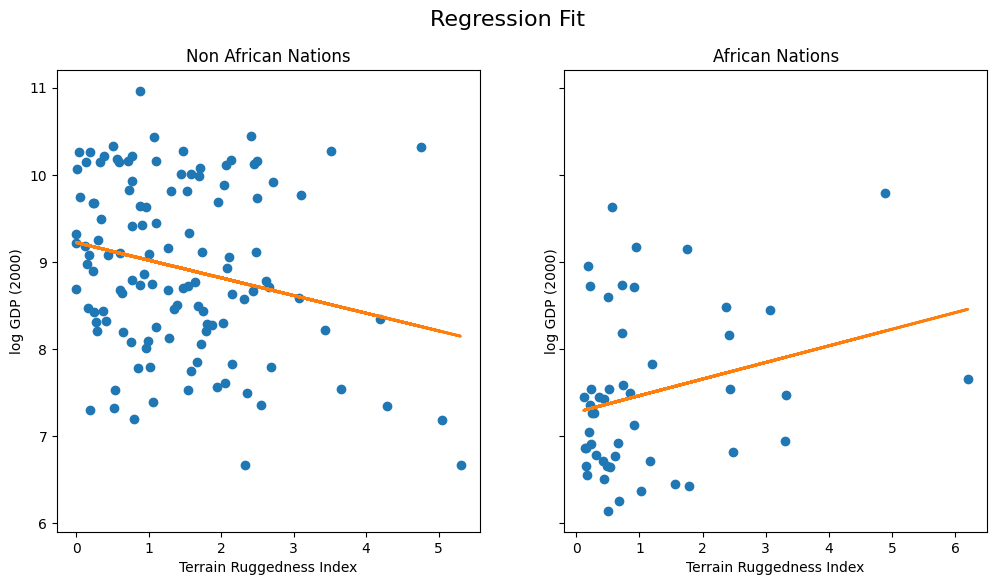

In [13]:
fit = df.copy()
fit["mean"] = linear_reg_model(x_data).detach().cpu().numpy()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
african_nations = fit[fit["cont_africa"] == 1]
non_african_nations = fit[fit["cont_africa"] == 0]
fig.suptitle("Regression Fit", fontsize=16)
ax[0].plot(non_african_nations["rugged"], non_african_nations["rgdppc_2000"], "o")
ax[0].plot(non_african_nations["rugged"], non_african_nations["mean"], linewidth=2)
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
ax[1].plot(african_nations["rugged"], african_nations["rgdppc_2000"], "o")
ax[1].plot(african_nations["rugged"], african_nations["mean"], linewidth=2)
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations");

